In [1]:
import glob
import json
import random

Download Dataset:
https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge

In [4]:
json_files = glob.glob('crater_env/Datasets/spotify_million_playlist_dataset/data/mpd.slice.*.json')

In [12]:
# Sample approximately 10% of the files
sampled_files = random.sample(json_files, k=int(len(json_files) * .02))

sampled_playlists = []
for file_path in sampled_files:
    with open(file_path, 'r') as file:
        data = json.load(file)
        sampled_playlists.extend(data['playlists'])

In [17]:
playlist_names = [playlist['name'] for playlist in sampled_playlists]

In [18]:
len(playlist_names)

20000

# Token

In [19]:
from transformers import BertTokenizer


# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize each playlist name and find the maximum length
max_len = 0
for name in playlist_names:
    tokens = tokenizer.encode(name, add_special_tokens=True)  # add_special_tokens=True includes [CLS] and [SEP]
    max_len = max(max_len, len(tokens))

print(f"The maximum sequence length among the playlist names is: {max_len}")

The maximum sequence length among the playlist names is: 16


In [20]:
from transformers import BertTokenizer, BertModel
import torch

# Initialize the tokenizer and model from the pre-trained 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_playlist_embeddings(playlist_names, batch_size=32):
    # Convert the list of names into batches
    batches = [playlist_names[i:i + batch_size] for i in range(0, len(playlist_names), batch_size)]
    all_embeddings = []

    for batch in batches:
        # Tokenize the batch
        inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=20, add_special_tokens=True)

        # Generate embeddings
        with torch.no_grad():
            outputs = model(**inputs)

        # Take the mean of the embeddings for each input in the batch
        embeddings = outputs.last_hidden_state.mean(dim=1)
        all_embeddings.append(embeddings)

    # Concatenate all batch embeddings into a single tensor
    embeddings_tensor = torch.cat(all_embeddings, dim=0)
    return embeddings_tensor


In [24]:
# Example usage:
playlist_names = playlist_names  # Replace these with your playlist names
embeddings = get_playlist_embeddings(playlist_names)

In [29]:
import numpy as np
import torch
from sklearn.decomposition import PCA

# Simulate loading your embeddings (assuming it's a PyTorch tensor for demonstration)
# Shape [20000, 768] indicates 20,000 samples with 768-dimensional embeddings each
# For actual use, replace this with loading your tensor
# embeddings = torch.rand(20000, 768)  # Random data for the sake of example

# Convert PyTorch tensor to NumPy array if necessary
embeddings_numpy = embeddings.numpy() if isinstance(embeddings, torch.Tensor) else embeddings

# Initialize PCA
pca = PCA(n_components=2)

# Apply PCA on the embeddings
embeddings_reduced = pca.fit_transform(embeddings_numpy)

print("Reduced embeddings shape:", embeddings_reduced.shape)



Reduced embeddings shape: (20000, 2)


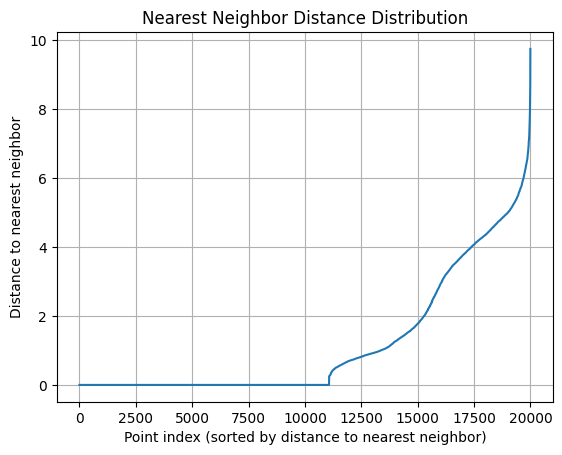

In [41]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Assuming 'embeddings' is your NumPy array of shape (n_samples, n_features)
# For large datasets, consider using a random sample:
# sample_embeddings = embeddings[np.random.choice(embeddings.shape[0], size=1000, replace=False), :]

# Step 1: Calculate pairwise distances
# Note: This can be memory-intensive for large datasets, consider using a sample as noted above
distances = pdist(embeddings, metric='euclidean')
dist_matrix = squareform(distances)

# Step 2: Compute the distance to the nearest neighbor for each point
nearest_neighbor_distances = np.sort(dist_matrix, axis=1)[:, 1]  # The first column is the distance to itself (0), so we take the second column

# Step 3: Plot the distribution of nearest neighbor distances to find a suitable 'eps'
plt.plot(np.sort(nearest_neighbor_distances))
plt.xlabel('Point index (sorted by distance to nearest neighbor)')
plt.ylabel('Distance to nearest neighbor')
plt.title('Nearest Neighbor Distance Distribution')
plt.grid(True)
plt.show()

# Look for an "elbow" in the plot to choose a value for 'eps'


In [569]:
from sklearn.cluster import DBSCAN
import pandas as pd

# Assuming embeddings_reduced is your 2D embeddings data from PCA or directly your embeddings
dbscan = DBSCAN(eps=.05, min_samples=10)  # eps and min_samples are key parameters to adjust
clusters = dbscan.fit_predict(embeddings_reduced)

# Note: DBSCAN labels noise points (outliers) with the label -1

In [570]:
len(set(clusters))

391

In [571]:
clust_df = pd.DataFrame(zip(clusters, playlist_names), columns = ['cluster','name'])
len(clust_df[clust_df.cluster ==-1])

7845

In [572]:
len(clust_df[clust_df.cluster ==-1]), len(clust_df[clust_df.cluster == 0])

(7845, 27)

In [574]:
from scipy.spatial.distance import cdist
import numpy as np

def find_cluster_representatives(playlist_names, embeddings_reduced, cluster_labels):
    representatives = {}
    for cluster in np.unique(cluster_labels):
        if cluster == -1:  # Skip noise if using DBSCAN
            continue
        cluster_indices = np.where(cluster_labels == cluster)[0]
        cluster_embeddings = embeddings[cluster_indices]
        
        # Compute distances within the cluster
        distances = cdist(cluster_embeddings, cluster_embeddings, metric='euclidean')
        avg_distances = distances.mean(axis=1)
        
        # Find the index of the minimum average distance
        representative_idx = cluster_indices[avg_distances.argmin()]
        representatives[cluster] = playlist_names[representative_idx]
    
    return representatives


In [575]:
# Assuming 'playlist_names', 'embeddings', and 'clusters' are your data
representatives = find_cluster_representatives(playlist_names, embeddings_reduced, clusters)
print(representatives)

{0: '2016', 1: 'calm', 2: 'Salsa', 3: 'Chill Vibes', 4: 'wedding', 5: 'Christmas', 6: 'Chillax', 7: 'Reggae ', 8: 'Rock', 9: 'my music', 10: 'CHRISTMAS', 11: 'Fun', 12: 'THROW BACK ', 13: 'covers', 14: 'classics', 15: 'Throwbacks', 16: 'Worship', 17: 'memory lane ', 18: 'sunshine', 19: 'Wedding Playlist', 20: 'My music', 21: 'lol', 22: 'Sunrise', 23: 'DANCE', 24: 'Worship', 25: 'car', 26: 'party', 27: 'Old School', 28: 'Sleep', 29: 'Disney', 30: 'beachin', 31: 'Oldies but Goodies', 32: 'Sad', 33: 'Reggae', 34: 'throwback', 35: 'Dad', 36: 'Classics', 37: 'runaway', 38: '2015', 39: 'gaming', 40: 'Morning Drive ', 41: 'stuff', 42: 'my jams', 43: 'pregame', 44: '🔥🔥🔥🔥', 45: 'New Wave', 46: 'Jams', 47: 'Savage', 48: 'feels', 49: 'beach', 50: 'Rock', 51: 'dope', 52: 'new', 53: 'Metal', 54: 'R&B', 55: 'Crazy', 56: 'summer 2017', 57: 'Classical', 58: 'happy ', 59: 'TBT', 60: 'feels', 61: 'Guilty Pleasures', 62: 'Pump Up', 63: 'summer feels', 64: 'christmas ', 65: 'Good stuff', 66: 'lit', 67: 'N

In [576]:
playlist_reps = representatives.values()

In [577]:
final_playlist = pd.DataFrame(list(set([i.lower().strip() for i in playlist_reps])), columns = ['names'])

In [578]:
final_playlist.to_csv('crater_env/assets/playlists_for_search.csv', index = False)

In [583]:
list(final_playlist.names[:20])

['dad',
 'groovy',
 'morning drive',
 'guilty pleasures',
 'slow songs',
 'mood',
 '2017',
 'halloween',
 'dope',
 'electronic',
 'party',
 'summer 2014',
 'pump up',
 'running',
 'spring 2017',
 'good vibes',
 'happy',
 '🔥🔥🔥🔥',
 'kpop',
 'turn up']